
# Data

The data in the csv file is from premier league games from 00/01 season through to the end of January of the current season, 18/19. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

filepath = "/Users/RichardMcDermott/Desktop/Football Radar/Premier League.csv"

df = pd.read_csv(filepath, dtype={'season': str})

display(df.head())

,Unnamed: 0,home_team,away_team,date,home_goals,away_goals,referee,home_fouls,away_fouls,home_yellow_cards,away_yellow_cards,home_red_cards,away_red_cards,season
0,0,Charlton,Man City,2000-08-19,4,0,Rob Harris,13,12,1,2,0,0,0001
1,1,Chelsea,West Ham,2000-08-19,4,2,Graham Barber,19,14,1,2,0,0,0001
2,2,Coventry,Middlesbrough,2000-08-19,1,3,Barry Knight,15,21,5,3,1,0,0001
3,3,Derby,Southampton,2000-08-19,2,2,Andy D'Urso,11,13,1,1,0,0,0001
4,4,Leeds,Everton,2000-08-19,2,0,Dermot Gallagher,21,20,1,3,0,0,0001


In [2]:
df.groupby(['season']).size()

season
0001    380
0102    380
0203    316
0304    335
0405    335
0506    380
0607    380
0708    380
0809    380
0910    380
1011    380
1112    380
1213    380
1314    380
1415    380
1516    380
1617    380
1718    380
1819    240
dtype: int64


The table above shows that the data is fully populated for all seasons (380 games per season) except for seasons 02/03, 03/04 and 04/05 (and of course the current season that is yet to be completed). For the purpose of this task, I'll not attempt to retrieve the missing data but instead I'll assume the games present in the data are representative of that season. For example, the 316 games in 02/03 in the data are representative of the 380 games that were played that season in regards to the number of yellow and red cards shown.



# 1. Comparing yellow cards this season to previous seasons


In [3]:
df_yellow = pd.DataFrame(data={'Season': df['season'], 'Date': df['date'], 
                'Yellow_Cards': df['home_yellow_cards']+df['away_yellow_cards']})
# total yellow cards (home + away)

df_yellow_past = df_yellow[~(df_yellow['Season'].isin(['1819']))].reset_index(drop=True)
df_yellow_cur = df_yellow[df_yellow['Season'].isin(['1819'])].reset_index(drop=True)

avg_yellow_past = df_yellow_past['Yellow_Cards'].mean().round(4)
avg_yellow_cur = df_yellow_cur['Yellow_Cards'].mean().round(4)

print("Yellow Cards Per Match (0001-1718): %.4f" % avg_yellow_past)
print("Yellow Cards Per Match (1819):      %.4f" % avg_yellow_cur)

Yellow Cards Per Match (0001-1718): 3.1636
Yellow Cards Per Match (1819):      3.2458



It should be noted first that 2 yellow cards shown to the same player within the same game is classed as 1 red card and 0 yellow cards.

The average number of yellow cards in the current season (18/19) is 3.2458 per game. This is higher than the average number of yellow cards from season 00/01 through to 17/18 when it was 3.1636 per game.

Is this difference significant, or is it due to chance?

If we knew the underlying distribution of ‘yellow cards per game’, we could assess whether the 3.2458 per game from this season is higher than we’d expect considering natural variance. We can first consider that yellow cards follow an independent Poisson distribution. This means that yellow cards are shown at a constant rate and they are unimpacted by previous yellow cards during the same game. Let’s check to see if the Poisson distribution is a good fit for our yellow cards data.


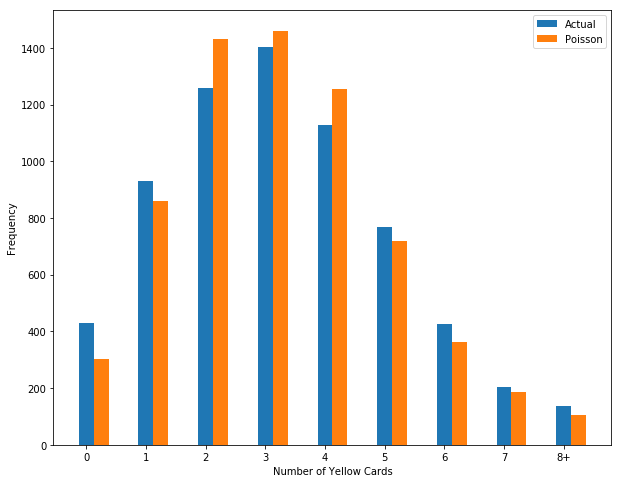

In [4]:
yellow_occ_past = df_yellow_past.groupby(['Yellow_Cards']).size().values
yellow_occ_past = np.hstack([yellow_occ_past[:8],np.sum(yellow_occ_past[8:])]) # cap at 8

poisson_sample = np.random.poisson(df_yellow_past['Yellow_Cards'].mean()
                        , len(df_yellow_past['Yellow_Cards']))
poisson_sample = np.clip(poisson_sample,0,8) # cap at 8
poisson_sample_values, poisson_sample_counts = np.unique(poisson_sample, return_counts=True)

bars = len(yellow_occ_past) # number of bars
ind = np.arange(bars) # the x locations for the bars
width = 0.25 # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(10,8))
bars1 = ax.bar(ind, yellow_occ_past,width)
bars2 = ax.bar(ind+0.25, poisson_sample_counts,width)
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Yellow Cards')
ax.set_xticks(ind)
ax.set_xticklabels(('0','1','2','3','4','5','6','7','8+'))
ax.legend((bars1, bars2), ('Actual', 'Poisson'))
plt.show()


The chart above shows the actual yellow cards per game distribution from past seasons (00/01-17/18) in blue against a Poisson sample with mean 3.1636 in orange. As you can see the actual data does not fit the Poisson very well and I wouldn’t feel comfortable using it as an approximation for our yellow card data.

(Note: I could confirm this by simulating the Poisson sample several times (10,000+) and then creating intervals from the 2.5 and 97.5 percentiles at each X to see if the actual data fits within the intervals).

The actual data is over dispersed, this intuitively make sense from a practical view. During a football game despite an aim for consistency that would help ensure yellow cards are given out independently from each other. This is in reality, rarely achieved. Referees can be hesitant to give out yellow cards early in games as the threshold of offense seems to be higher resulting in a greater number of 0 and 1 yellows cards per game than expected if following a Poisson distribution. On the flip side, if there is a yellow card shown early in the game, this can open the flood gates and we observe a greater number of 5+ yellow cards than expected. To combat this, we could use the negative binomial distribution as this allows us to model the over dispersion by estimated a second parameter (along with the mean).

However, for this task, I’ll use the central limit theorem by taking samples from the actual data and calculate the means of these samples. These will follow a normal distribution. I can then carry out a z-test using the distribution against the mean of the current season (3.2458) to assess whether the null hypothesis should be rejected.


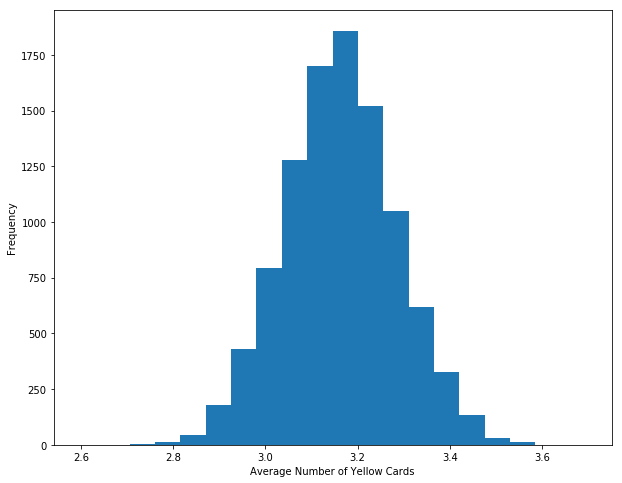

In [5]:
sampleMeans = []
for i in range(10000):
    samples = df_yellow_past['Yellow_Cards'].sample(n=240, replace=True, random_state=i)
    # 240 matches sample size of current season, random_state ensures re-productivity of results
    sampleMean = np.mean(samples)
    sampleMeans.append(sampleMean)

fig, ax = plt.subplots(1, 1, figsize=(10,8))
plt.hist(sampleMeans, bins=20)
ax.set_ylabel('Frequency')
ax.set_xlabel('Average Number of Yellow Cards')
plt.show()


As you can see the sample means are normalled distributed.


In [6]:
import scipy.stats as stats

zscore = (df_yellow_cur['Yellow_Cards'].mean() - np.mean(sampleMeans))/np.std(sampleMeans)
pval = stats.norm.cdf(-zscore)*2

print("P-Value: %.4f" % pval)

P-Value: 0.4931



By obtaining a z-score and converting this into a p-value, we do not reject the null hypothesis that the mean from past seasons and the mean from the current season are the same. Concluding that there is no evidence showing a difference in the number of yellow cards shown in this season compared to previous seasons.

However, this is just looking at a snap shot in time. What if the number of yellow cards were
increasing over time?


In [7]:
df_yellow_agg = df_yellow.groupby('Season', as_index=False).agg({'Yellow_Cards': ["count", "sum", "mean"]})
df_yellow_agg.columns = ["_".join(x) for x in df_yellow_agg.columns.ravel()]
df_yellow_agg = df_yellow_agg.rename(columns={'Yellow_Cards_count': 'Games'}).round(4)
df_yellow_agg

,Season_,Games,Yellow_Cards_sum,Yellow_Cards_mean
0,0001,380,1194,3.1421
1,0102,380,1165,3.0658
2,0203,316,970,3.0696
3,0304,335,988,2.9493
4,0405,335,894,2.6687
5,0506,380,1173,3.0868
6,0607,380,1225,3.2237
7,0708,380,1216,3.2000
8,0809,380,1198,3.1526
9,0910,380,1237,3.2553



The table above shows the average number of yellows cards per game by season. As you can see the average number this season is higher than any of the seasons from 00/01 through to 08/09. This suggests there might be a general trend that shows an increase of yellow cards per game over the 19 seasons in the data.

Let’s plot these data points onto a chart to see visually if there is any trend. I’ll also add in a line of best fit by using linear regression with season as a predictor of yellow cards per game, along with 95% confidence interval of this best fit.


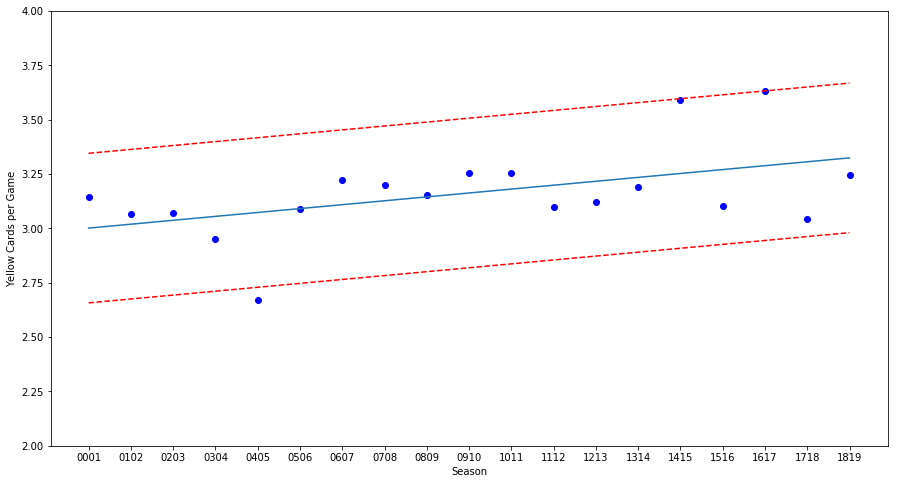

Gradient:  0.0179
P-Value:   0.0338
R-squared: 0.2387


In [8]:
from scipy.stats import linregress

x = df_yellow_agg['Season_'].index
y = df_yellow_agg['Yellow_Cards_mean']

# line of best fit (linear regression)
bestfit = []
for i in x:
    bestfit_val = linregress(x,y).intercept + x[i]*linregress(x,y).slope
    bestfit.append(bestfit_val) 

# calculate standard errrors of estimates to plot confidence interval of best fit
errors_sq = []
for i in x:
    error_val = y[i] - bestfit[i]
    errors_sq.append(error_val**2) 
see = np.sqrt(sum(errors_sq)/len(x))

# 95% confidence intervals
bestfit_upper = []
bestfit_lower = []
for i in x:
    bestfit_upper_val = bestfit[i] + 1.96*see
    bestfit_upper.append(bestfit_upper_val) 
    bestfit_lower_val = bestfit[i] - 1.96*see
    bestfit_lower.append(bestfit_lower_val)
    
    
fig, ax = plt.subplots(1, figsize=(15,8))
ax.plot(x, y, 'bo')
ax.set_ylim(2, 4)
line1 = ax.plot(x,bestfit,label='Linear Regression')
line2 = ax.plot(x,bestfit_upper, linestyle="--", color='red')
line3 = ax.plot(x,bestfit_lower, linestyle="--", color='red')
ax.set_xticks(df_yellow_agg['Season_'].index)
ax.set_xticklabels(df_yellow_agg['Season_'])
ax.set_ylabel('Yellow Cards per Game')
ax.set_xlabel('Season')
plt.show()

print("Gradient:  %.4f" % linregress(x,y).slope)
print("P-Value:   %.4f" % linregress(x,y).pvalue)
print("R-squared: %.4f" % linregress(x,y).rvalue**2)


We can indeed see a slight upward trend (blue line). The gradient is 0.0178 which states that there is an estimated increase of 0.0178 yellow cards per game for each new season. The p-value for the gradient is 0.0347 suggesting that there is some evidence showing that season is a good predictor of yellow cards per game. 

Of course, this model is far too simple to predict the number of yellow cards per game with great accuracy, as shown by the red dotted lines that provide a 95% confidence interval around the best fit line (they're very wide!). However, it does indicate that yellow cards per game is on the rise.

Again, this makes sense practically, the premier league in this timespan has increased its profile and host an increasing number of world class players. The game is played at a higher speed than before which yields more fouls and hence increases the chances of yellow cards being shown. Also due to the increase in profile and revenue, there’s an argument that players are protected from injuries more and hence there is a greater pressure on referees to prevent potentially dangerous tackles and to control the game. They can do this by showing more cards.



# 2. Which Referee is most likely to show a red card



Firstly we need to standardise the referee names, so for example, M Dean and Mike Dean are viewed as the same person.

The table below shows the sum of red cards and average number of red cards per game by referee. The referee must have had a minimum of 25 games recorded in the data.

From first view we see that B Knight has the highest number of red cards per game of all the referees. 17 red cards in 59 games equalling 0.2881 red cards per game. However, 59 games isn't many particurly when asssesing relatviely rare occurring events such as red cards. For example if he had shown a handful of fewer red cards, for example 12 instead of 17, 0.2034 reds per game would have had him down in 7th place.

It brings into question the certaincy of these estimates and how confident (or unconfident) we are of that them.


In [9]:
# Reformat Referee Name to [Initial Surname] (eg, R McDermott)
referee_new = []
for i in df['referee']:
    initial = i.split()[0][0]
    surname = i.split()[-1]
    referee_new_input = initial + ' ' + surname
    referee_new.append(referee_new_input)

df['referee_new'] = referee_new
df['Red_Cards'] = df['home_red_cards'] + df['away_red_cards'] # total red cards (home + away)

df_referee_agg = df.groupby('referee_new', as_index=False).agg({'Red_Cards': ["count", "sum", "mean"]})
df_referee_agg.columns = ["_".join(x) for x in df_referee_agg.columns.ravel()]
df_referee_agg = df_referee_agg.rename(columns={'Red_Cards_count': 'Games'}).round(4)
df_referee_agg[(df_referee_agg['Games'] >= 25)].sort_values(by='Red_Cards_mean'
                                , ascending=False).reset_index(drop=True) # min 25 games

,referee_new_,Games,Red_Cards_sum,Red_Cards_mean
0,B Knight,59,17,0.2881
1,A D'Urso,93,24,0.2581
2,R Styles,203,52,0.2562
3,M Riley,198,46,0.2323
4,P Dowd,300,64,0.2133
5,S Bennett,233,49,0.2103
6,M Dean,463,97,0.2095
7,D Elleray,52,10,0.1923
8,D Gallagher,116,22,0.1897
9,G Barber,75,14,0.1867



Again we need to understand the underlying distribution of red cards to assess confidence in the red card per game estimates.

Lets try the Poisson distribution again. 


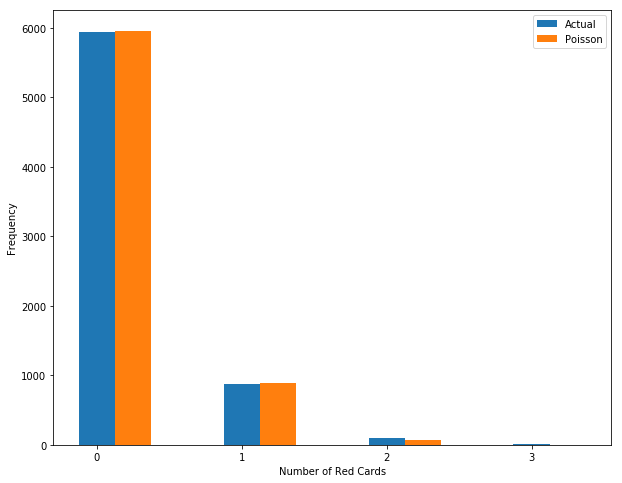

In [10]:
red_cards = df.groupby(['Red_Cards']).size().values

sim = np.random.poisson(df['Red_Cards'].mean()
                        , len(df['Red_Cards']))
sim_values, sim_counts = np.unique(sim, return_counts=True)

bars = len(red_cards) # number of bars
ind = np.arange(bars) # the x locations for the bars
width = 0.25 # the width of the bars

fig, ax = plt.subplots(1, 1, figsize=(10,8))
bars1 = ax.bar(ind, red_cards,width)
bars2 = ax.bar(ind+0.25, sim_counts,width)
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Red Cards')
ax.set_xticks(ind)
ax.set_xticklabels(('0','1','2','3'))
ax.legend((bars1, bars2), ('Actual', 'Poisson'))
plt.show()


This time we see that the Poisson distribtion fits our red card data much better.

Lets go ahead and fit a poisson regression model (glm), by using referee as a predictor for red cards we get the estimates for reds per game for each referee. The estimates should equal the means in the table above. But in addition we will get the standard errors of the estimates to enable us to calculate confidence intervals of the estimates.

Again we restrict the analysis to referees that have at least officiated 25 games.


In [11]:
import statsmodels.formula.api as smf
import statsmodels.api as sm

# only include referees with at least 25 games
referee_to_inc = df_referee_agg[(df_referee_agg['Games'] >= 25)]['referee_new_'].reset_index(drop=True)
df_model = df[df['referee_new'].isin(referee_to_inc)].reset_index(drop=True)

# fit poisson model with referee as predictor of number red cards
poisson_model = smf.glm(formula="Red_Cards ~ referee_new-1", 
            data=df_model,
            family=sm.families.Poisson()).fit()

# return estimates of red cards per match with 95% confidence intervals of estimate
df_ref_estimates = pd.DataFrame(data={'Reds_per_game': np.exp(poisson_model.params),
                'Reds_per_game_lower': np.exp(poisson_model.conf_int(alpha=0.05)[0]),
                'Reds_per_game_upper': np.exp(poisson_model.conf_int(alpha=0.05)[1])
                                     })

df_ref_estimates.round(4)

,Reds_per_game,Reds_per_game_lower,Reds_per_game_upper
referee_new[A D'Urso],0.2581,0.1730,0.3850
referee_new[A Marriner],0.1794,0.1374,0.2342
referee_new[A Taylor],0.1402,0.0980,0.2005
referee_new[A Wiley],0.1311,0.0927,0.1855
referee_new[B Knight],0.2881,0.1791,0.4635
referee_new[C Foy],0.1467,0.1068,0.2016
referee_new[C Kavanagh],0.0968,0.0312,0.3001
referee_new[C Pawson],0.1680,0.1095,0.2577
referee_new[C Wilkes],0.1786,0.0743,0.4290
referee_new[D Elleray],0.1923,0.1035,0.3574



As you can see the reds per game estimates match the mean reds per game in the table before. Now we have the additional 2 columns that provide us the 95% confidence intervals around those estimates. 

Below is a chart that displays this data. The blue dots represent the estimates of reds per game for each referee and the error bars represent the 95% confidence interval around those estimates.


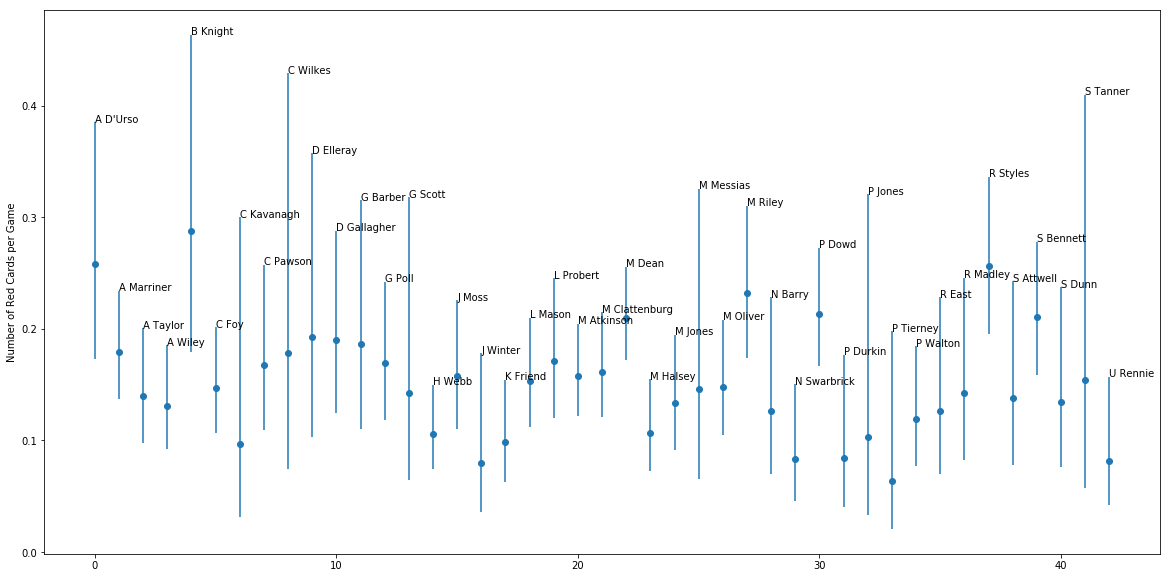

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
x = referee_to_inc.index
y = df_ref_estimates['Reds_per_game']
# calculate error bars
e = np.vstack([df_ref_estimates['Reds_per_game']-df_ref_estimates['Reds_per_game_lower']
           ,df_ref_estimates['Reds_per_game_upper']-df_ref_estimates['Reds_per_game']])
plt.errorbar(x, y, yerr=e, fmt='o')
# annotate chart to show referee names
for i in referee_to_inc.index:
    plt.annotate(referee_to_inc[i], xy=(i,e[1][i]+y[i]))
ax.set_ylabel('Number of Red Cards per Game')
plt.show()


Unfortunately the error bars are very big for most referees. Even M Dean who has officiated 463 games has an interval that is 0.0839 wide. This means that if we were certain about all other referee reds per game, then M Dean could still vary from 4th to 11th most likely.

B Knight, who has the highest estimate, again given certaincy regarding all other referees reds per game, could be ranked as low as 10th.

So there is no indication of most likely to send a player off that we can provide with confidence. B Knight has the highest estimate, but R Styles has the highest lower confidence interval value, so there's a good arguement that he would be a good choice as most likely to send a player off.

There are some referees that we can rule out. R Styles has the highest lower confidence interval value (0.1952), and there are 10 referees who's high confidence interval value is lower than 0.1952.

We can run the same analysis again but for current referees to check if there's a clear leader in that subset.


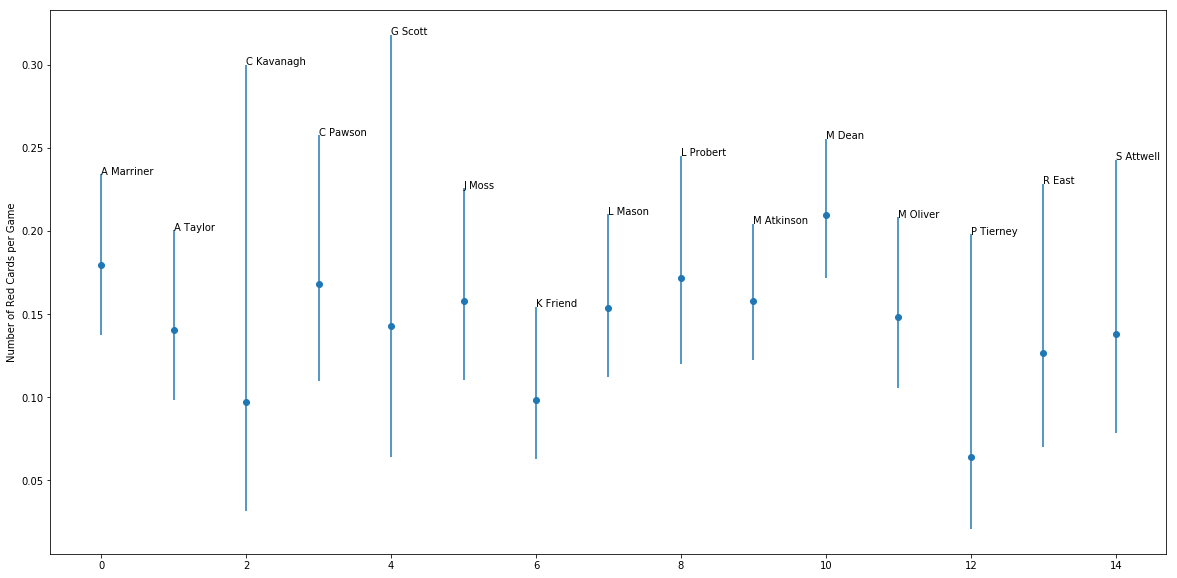

In [13]:
# only include current referees with at least 25 games
current_refs = df[df['season'].isin(['1819'])]['referee_new'].reset_index(drop=True).unique()
referee_to_inc = df_referee_agg[(df_referee_agg['Games'] >= 25) &
                                (df_referee_agg['referee_new_'].isin(current_refs))
                               ]['referee_new_'].reset_index(drop=True)
df_model_cur = df[df['referee_new'].isin(referee_to_inc)].reset_index(drop=True)

poisson_model_cur = smf.glm(formula="Red_Cards ~ referee_new-1", 
            data=df_model_cur,
            family=sm.families.Poisson()).fit()

df_ref_estimates_cur = pd.DataFrame(data={'Reds_per_game': np.exp(poisson_model_cur.params),
                'Reds_per_game_lower': np.exp(poisson_model_cur.conf_int(alpha=0.05)[0]),
                'Reds_per_game_upper': np.exp(poisson_model_cur.conf_int(alpha=0.05)[1])
                                     })
fig, ax = plt.subplots(1, 1, figsize=(20,10))
x = referee_to_inc.index
y = df_ref_estimates_cur['Reds_per_game']
e = np.vstack([df_ref_estimates_cur['Reds_per_game']-df_ref_estimates_cur['Reds_per_game_lower']
           ,df_ref_estimates_cur['Reds_per_game_upper']-df_ref_estimates_cur['Reds_per_game']])
plt.errorbar(x, y, yerr=e, fmt='o')
for i in referee_to_inc.index:
    plt.annotate(referee_to_inc[i], xy=(i,e[1][i]+y[i]))
ax.set_ylabel('Number of Red Cards per Game')
plt.show()


M Dean has the largest estimate of reds per game and the highest lower confidence interval value. However we still cannot say with confidence that he would be most likely to send a player off as other referees high confidence interval value overlaps M Dean.

In fact the only confidence we can provide is that M Dean is more likely to send a player off than K Friend of current referees. As there is no overlap.

Also we should be careful as timeframe has not been taken into account. For example if we find that M Dean has sent 90 players off in the his last 100 games then that would be important to know. So for a more robust model we could add weight to more recent games for example. This may provide more accurate estimates. 



# Summary

The number of yellow cards this season is higher than previos seasons in the data, 3.2458 compared to 3.1636 per game. However, this difference was found not to be significant.

When plotting the number of yellow cards per game over time, there was some evidence suggesting that there is an upward trend. The gradient of the regression line was 0.0179 indicating that as seasons go by there is a 0.0179 increase in yellow cards per game each season. There is of course a lot of variance surrounding this estimate but nonetheless it does show a change in premier league football over the past 19 seasons.

Of all referees in the data who had officiated at least 25 games, B Knight had the highest number of red cards per game at 0.2881. Although the error around these estimates were large resulting in a lot of uncertaincy. R Styles had the highest lower confidence interval value which puts in a strong arguement that he is contender for most likely to send a player off. Having said that, 32 of the 42 referees assessed had high confidence interval values larger than all low confidence interval values. Therefore we could only rule out 10 referees.

Of the current referees, M Dean had the highest number of red cards per game at 0.2095, but again there was a lot of overlap of confidence intervals. M Dean also had the highest low confidence interval value which was higher than K Friend's high confidence interval value. So we can rule out with confidence that K Friend is most likely to send a player off. All evidence points to M Dean but we cannot be certain.
